# Library Imports

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import csv
import seaborn as sns
from urllib.parse import unquote
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from src.data.paths_loader import load_ai_paths, load_human_paths
from src.utils.evaluation_utils import *


# Content
// TODO: merge

# Data Loading and Preprocessing


In [51]:
paths_df = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", sep="\t", comment='#', header=None,
                       names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])

In [52]:
links_df = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv', sep='\t', comment='#', header=None, names=['origin', 'destination'])
# Create directed graph
G = nx.from_pandas_edgelist(links_df, source='origin', target='destination', create_using=nx.DiGraph())

# load the origin and destination pairs, in the first column
ori_dest = pd.read_csv('ori_dest.csv').iloc[:, 0].tolist()
ori_dest = [eval(pair) for pair in ori_dest]

In [53]:
categories_df = pd.read_csv('data/wikispeedia_paths-and-graph/categories.tsv',
                        sep='\t',
                        comment='#',
                        header=None,
                        names=['article', 'category'])
# unquote
categories_df = categories_df.map(unquote)

# Exploratory Data Analysis

## Path Length Analysis

In [54]:
# Calculate path length
paths_df["path_length"] = paths_df["path"].apply(lambda x: len(x.split(';')))

print("Average corrected path length:", paths_df["path_length"].mean())
print("Corrected path length distribution:\n", paths_df["path_length"].value_counts())

Average corrected path length: 6.757434038738844
Corrected path length distribution:
 path_length
5     10941
4      8558
6      8137
7      5868
8      3954
      ...  
72        1
86        1
71        1
66        1
69        1
Name: count, Length: 79, dtype: int64


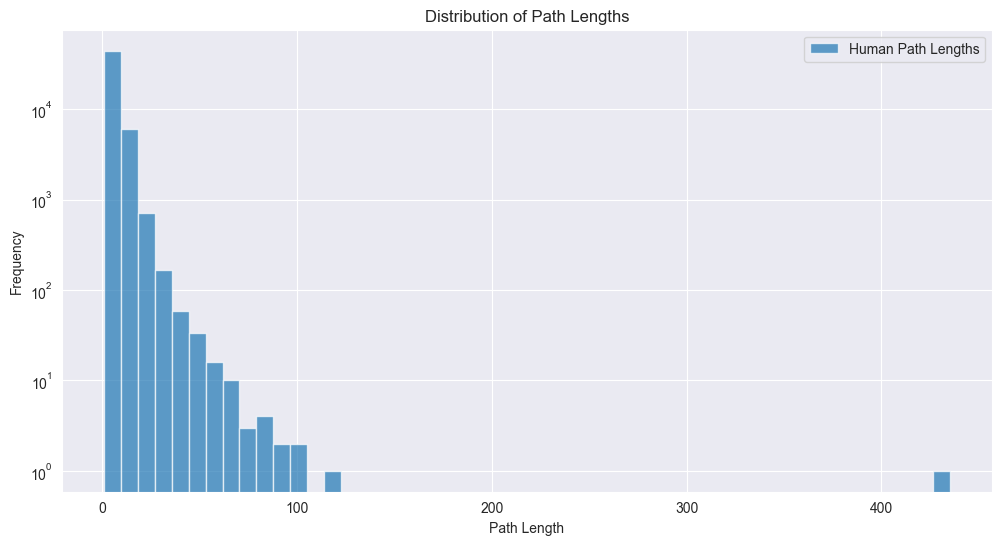

In [55]:
plt.figure(figsize=(12, 6))

# Plot human path lengths
plt.hist(paths_df["path_length"].dropna(), bins=50, alpha=0.7, label='Human Path Lengths')

# Add labels and title
plt.xlabel("Path Length")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Path Lengths")
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [56]:
# Get the optimal path length
shortest_path_matrix = dict(nx.all_pairs_shortest_path_length(G))

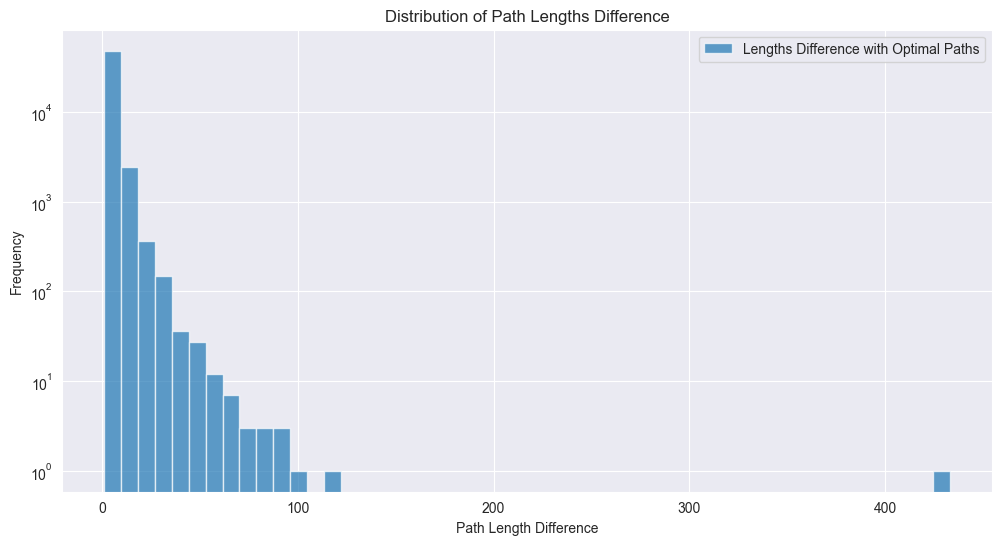

In [57]:
def calculate_shortest_path_length(path):
    articles = path.split(';')
    start_article = articles[0]
    end_article = articles[-1]
    if start_article != end_article:
        try:
            return shortest_path_matrix[start_article][end_article]
        except KeyError:
            return np.nan
    return 0

paths_df["shortest_path_length"] = paths_df["path"].apply(calculate_shortest_path_length)
paths_df["path_length_difference"] = paths_df["path_length"] - paths_df["shortest_path_length"]

plt.figure(figsize=(12, 6))

# Plot human path lengths
plt.hist(paths_df["path_length_difference"].dropna(), bins=50, alpha=0.7, label='Lengths Difference with Optimal Paths')

# Add labels and title
plt.xlabel("Path Length Difference")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Path Lengths Difference")
plt.legend(loc='upper right')

# Show the plot
plt.show()

# Comparison with LLM
- Biases in Human and LLM Choices
    - Article Categories


In [58]:
# for each pair, load the AI generated path and the human navigated path
AI_paths = load_ai_paths('paths', ori_dest)
human_paths = load_human_paths(ori_dest)
shortest_paths = get_shortest_path(G, ori_dest)

In [73]:
ai_nodes_df = visualize_paths_treemap(AI_paths, categories_df, "AI Paths Category Treemap")

In [74]:
human_nodes_df = visualize_paths_treemap(human_paths, categories_df, "Human Paths Category Treemap")